## 1. Import Required Libraries

First, I'll import all the necessary libraries for data manipulation, visualization, and evaluation.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.datasets import make_blobs, load_iris
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import silhouette_score, davies_bouldin_score, calinski_harabasz_score
from sklearn.metrics import adjusted_rand_score, normalized_mutual_info_score
from scipy.spatial.distance import cdist
import warnings
warnings.filterwarnings('ignore')

# Set random seed for reproducibility
np.random.seed(42)

# Set style for better-looking plots
plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette("husl")

print("✓ All libraries imported successfully!")

✓ All libraries imported successfully!


## 2. Implementing K-Means From Scratch

Now comes the interesting part - writing our own K-Means implementation! I'll create a class that mimics sklearn's interface but implements everything from the ground up.

In [2]:
class KMeansFromScratch:
    """
    K-Means clustering implementation from scratch.

    This class implements the K-Means algorithm without using any pre-built
    clustering libraries, only numpy for mathematical operations.
    """

    def __init__(self, n_clusters=3, max_iterations=300, tolerance=1e-4, init_method='random'):
        """
        Initialize K-Means clustering.

        Parameters:
        -----------
        n_clusters : int, default=3
            Number of clusters to form
        max_iterations : int, default=300
            Maximum number of iterations
        tolerance : float, default=1e-4
            Convergence threshold
        init_method : str, default='random'
            Method for initializing centroids ('random' or 'kmeans++')
        """
        self.n_clusters = n_clusters
        self.max_iterations = max_iterations
        self.tolerance = tolerance
        self.init_method = init_method
        self.centroids = None
        self.labels_ = None
        self.inertia_ = None
        self.n_iterations_ = 0

    def _initialize_centroids(self, X):
        """
        Initialize centroids using either random selection or k-means++ method.
        """
        n_samples = X.shape[0]

        if self.init_method == 'random':
            # Randomly select k data points as initial centroids
            random_indices = np.random.choice(n_samples, self.n_clusters, replace=False)
            centroids = X[random_indices]

        elif self.init_method == 'kmeans++':
            # K-means++ initialization for better starting points
            centroids = []

            # Choose first centroid randomly
            centroids.append(X[np.random.randint(n_samples)])

            # Choose remaining centroids
            for _ in range(1, self.n_clusters):
                # Calculate distances from points to nearest centroid
                distances = np.array([min([np.linalg.norm(x - c)**2 for c in centroids]) for x in X])

                # Choose next centroid with probability proportional to distance squared
                probabilities = distances / distances.sum()
                cumulative_probs = probabilities.cumsum()
                r = np.random.rand()

                for idx, prob in enumerate(cumulative_probs):
                    if r < prob:
                        centroids.append(X[idx])
                        break

            centroids = np.array(centroids)

        return centroids

    def _calculate_distances(self, X, centroids):
        """
        Calculate Euclidean distances between data points and centroids.

        Returns a matrix of shape (n_samples, n_clusters)
        """
        distances = np.zeros((X.shape[0], self.n_clusters))

        for i, centroid in enumerate(centroids):
            # Calculate Euclidean distance for each centroid
            distances[:, i] = np.linalg.norm(X - centroid, axis=1)

        return distances

    def _assign_clusters(self, X, centroids):
        """
        Assign each data point to the nearest centroid.
        """
        distances = self._calculate_distances(X, centroids)
        labels = np.argmin(distances, axis=1)
        return labels

    def _update_centroids(self, X, labels):
        """
        Update centroid positions based on mean of assigned points.
        """
        centroids = np.zeros((self.n_clusters, X.shape[1]))

        for k in range(self.n_clusters):
            # Get all points assigned to cluster k
            cluster_points = X[labels == k]

            if len(cluster_points) > 0:
                # Calculate mean of cluster points
                centroids[k] = cluster_points.mean(axis=0)
            else:
                # If cluster is empty, reinitialize randomly
                centroids[k] = X[np.random.randint(X.shape[0])]

        return centroids

    def _calculate_inertia(self, X, labels, centroids):
        """
        Calculate within-cluster sum of squares (inertia).
        """
        inertia = 0
        for k in range(self.n_clusters):
            cluster_points = X[labels == k]
            if len(cluster_points) > 0:
                inertia += np.sum((cluster_points - centroids[k])**2)
        return inertia

    def fit(self, X):
        """
        Fit K-Means clustering to the data.

        Parameters:
        -----------
        X : array-like, shape (n_samples, n_features)
            Training data
        """
        # Initialize centroids
        self.centroids = self._initialize_centroids(X)

        # Iterate until convergence or max iterations
        for iteration in range(self.max_iterations):
            # Store old centroids to check for convergence
            old_centroids = self.centroids.copy()

            # Assign clusters
            self.labels_ = self._assign_clusters(X, self.centroids)

            # Update centroids
            self.centroids = self._update_centroids(X, self.labels_)

            # Check for convergence
            centroid_shift = np.linalg.norm(self.centroids - old_centroids)

            if centroid_shift < self.tolerance:
                self.n_iterations_ = iteration + 1
                break
        else:
            self.n_iterations_ = self.max_iterations

        # Calculate final inertia
        self.inertia_ = self._calculate_inertia(X, self.labels_, self.centroids)

        return self

    def predict(self, X):
        """
        Predict cluster labels for new data.

        Parameters:
        -----------
        X : array-like, shape (n_samples, n_features)
            Data to predict
        """
        return self._assign_clusters(X, self.centroids)

    def fit_predict(self, X):
        """
        Fit the model and return cluster labels.
        """
        self.fit(X)
        return self.labels_

print("✓ K-Means class implemented successfully!")

✓ K-Means class implemented successfully!


## 3. Load and Prepare Dataset

For this demonstration, I'll use the classic Iris dataset. It's perfect for clustering because it has clear separations between different flower species. Let me load and explore it first.

In [3]:
# Load Iris dataset
iris = load_iris()
X = iris.data
y_true = iris.target  # We'll use this to evaluate our clustering
feature_names = iris.feature_names
target_names = iris.target_names

# Create a DataFrame for easier exploration
df = pd.DataFrame(X, columns=feature_names)
df['species'] = y_true
df['species_name'] = df['species'].map({0: target_names[0], 1: target_names[1], 2: target_names[2]})

print("Dataset Shape:", X.shape)
print("\nFirst few rows:")
print(df.head(10))
print("\nBasic Statistics:")
print(df.describe())

Dataset Shape: (150, 4)

First few rows:
   sepal length (cm)  sepal width (cm)  petal length (cm)  petal width (cm)  \
0                5.1               3.5                1.4               0.2   
1                4.9               3.0                1.4               0.2   
2                4.7               3.2                1.3               0.2   
3                4.6               3.1                1.5               0.2   
4                5.0               3.6                1.4               0.2   
5                5.4               3.9                1.7               0.4   
6                4.6               3.4                1.4               0.3   
7                5.0               3.4                1.5               0.2   
8                4.4               2.9                1.4               0.2   
9                4.9               3.1                1.5               0.1   

   species species_name  
0        0       setosa  
1        0       setosa  
2        0 

### Visualize the Raw Data

Let me create some visualizations to understand the data distribution before clustering.

<Figure size 1400x1000 with 0 Axes>

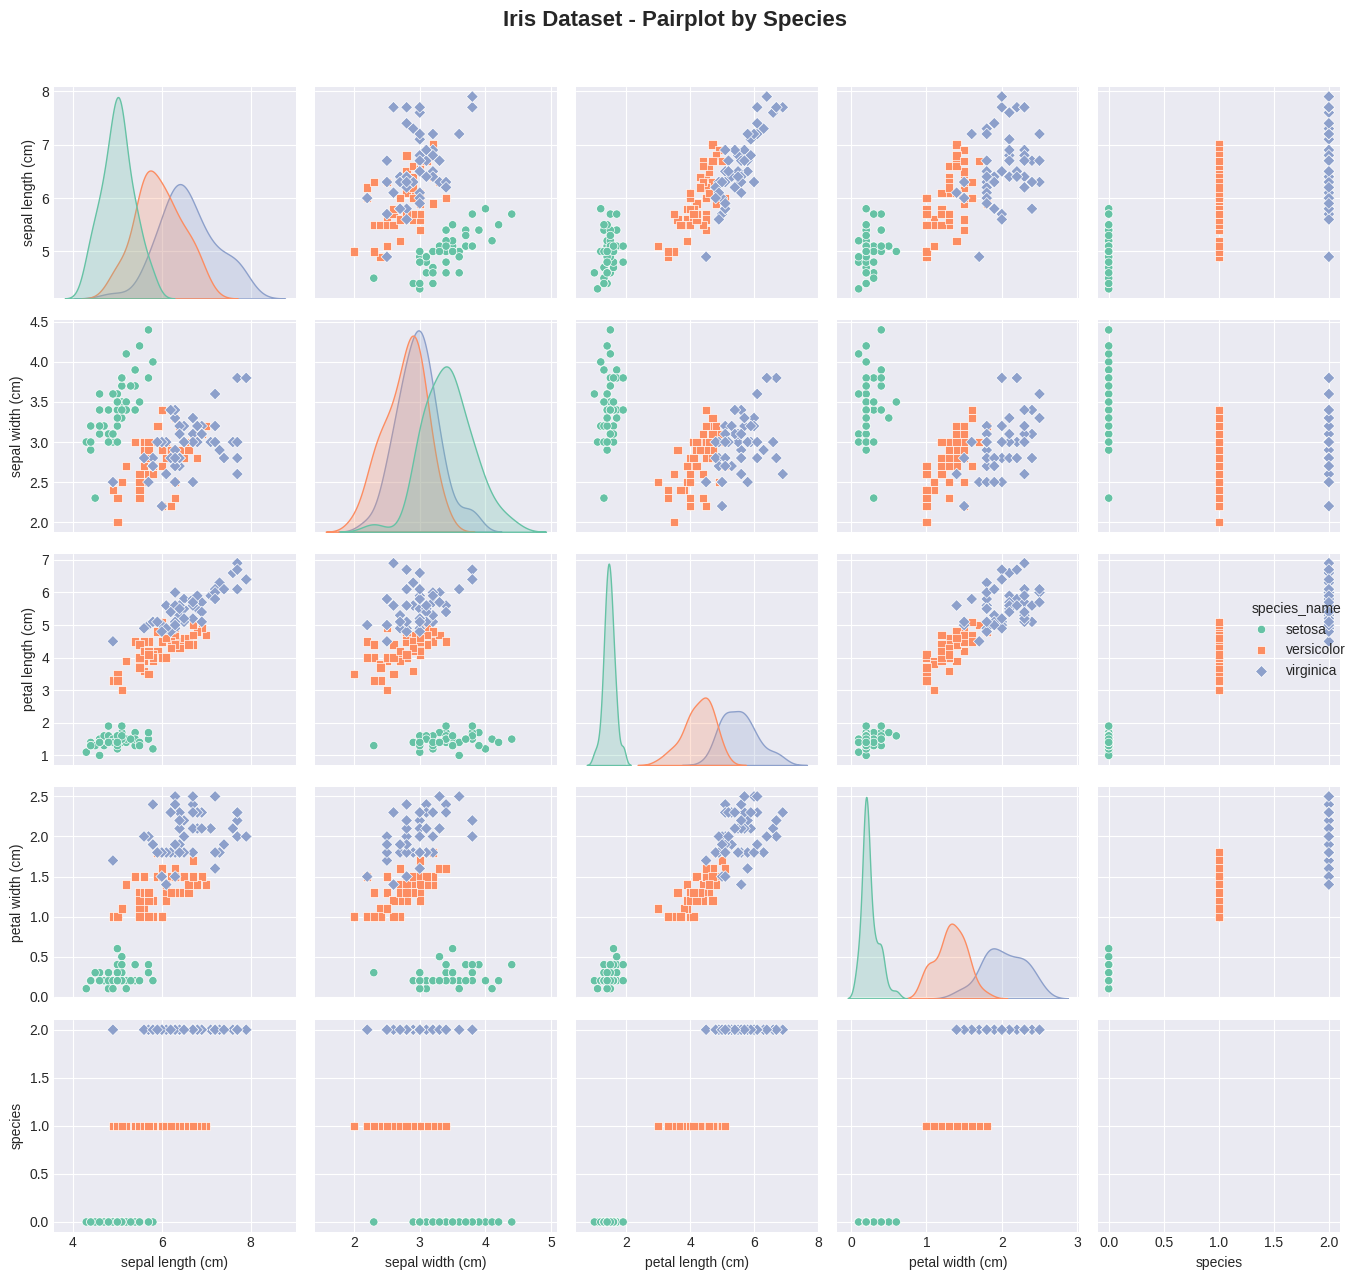

From the pairplot, we can see some natural clusters forming, especially when looking at
petal length vs petal width. This should make K-Means perform well!


In [4]:
# Create a pairplot to visualize relationships
fig = plt.figure(figsize=(14, 10))
sns.pairplot(df, hue='species_name', palette='Set2', diag_kind='kde', markers=['o', 's', 'D'])
plt.suptitle('Iris Dataset - Pairplot by Species', y=1.02, fontsize=16, fontweight='bold')
plt.tight_layout()
plt.show()

print("From the pairplot, we can see some natural clusters forming, especially when looking at")
print("petal length vs petal width. This should make K-Means perform well!")

### Data Preprocessing

K-Means is sensitive to feature scales because it uses Euclidean distance. Features with larger ranges will dominate the distance calculations. So I need to standardize the features to have zero mean and unit variance.

In [5]:
# Standardize features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

print("Original data - Mean and Std:")
print(f"Means: {X.mean(axis=0)}")
print(f"Stds: {X.std(axis=0)}")
print("\nScaled data - Mean and Std:")
print(f"Means: {X_scaled.mean(axis=0)}")
print(f"Stds: {X_scaled.std(axis=0)}")
print("\n✓ Features standardized successfully!")

Original data - Mean and Std:
Means: [5.84333333 3.05733333 3.758      1.19933333]
Stds: [0.82530129 0.43441097 1.75940407 0.75969263]

Scaled data - Mean and Std:
Means: [-1.69031455e-15 -1.84297022e-15 -1.69864123e-15 -1.40924309e-15]
Stds: [1. 1. 1. 1.]

✓ Features standardized successfully!


## 4. Finding Optimal Number of Clusters

Even though we know there are 3 species in the Iris dataset, let me demonstrate how to find the optimal K using the Elbow Method. This plots the within-cluster sum of squares (inertia) against different values of K.

Testing different values of K...
K=2: Inertia=222.362, Silhouette=0.582
K=3: Inertia=140.033, Silhouette=0.463
K=4: Inertia=114.354, Silhouette=0.382
K=5: Inertia=90.928, Silhouette=0.346
K=6: Inertia=81.520, Silhouette=0.346
K=7: Inertia=72.705, Silhouette=0.333
K=8: Inertia=65.955, Silhouette=0.294
K=9: Inertia=55.162, Silhouette=0.335
K=10: Inertia=50.953, Silhouette=0.360


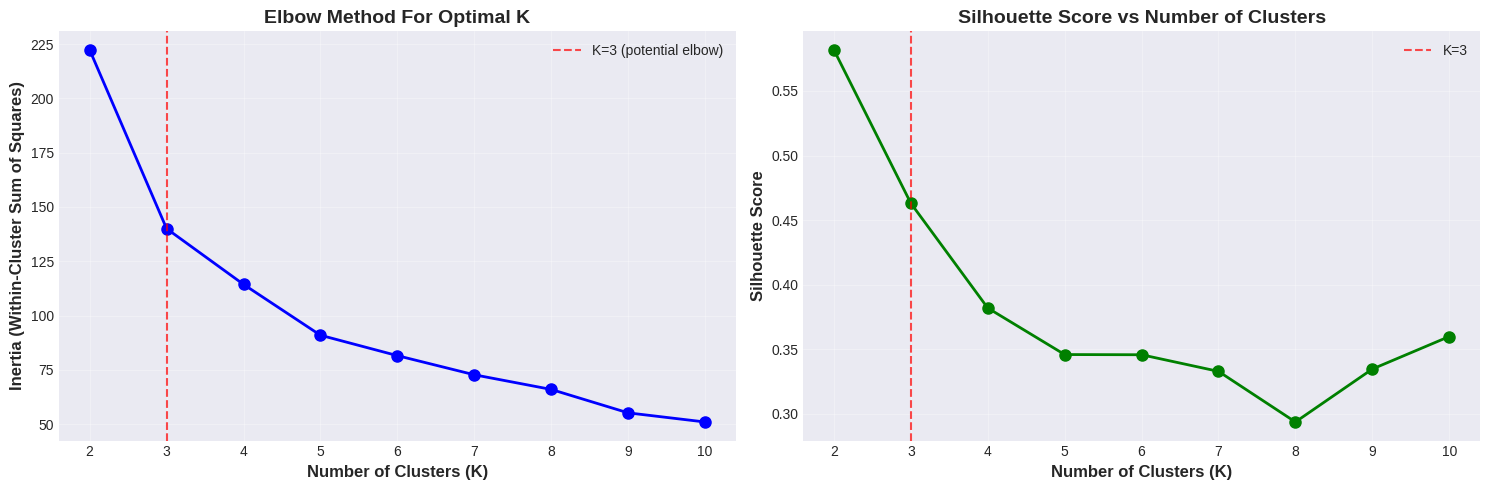


📊 Analysis:
The elbow appears around K=3, which matches our expected number of species!
K=3 also has a relatively high silhouette score of 0.463


In [6]:
# Calculate inertia for different values of K
inertias = []
silhouette_scores = []
K_range = range(2, 11)

print("Testing different values of K...")
for k in K_range:
    kmeans = KMeansFromScratch(n_clusters=k, init_method='kmeans++', max_iterations=300)
    kmeans.fit(X_scaled)
    inertias.append(kmeans.inertia_)
    silhouette_scores.append(silhouette_score(X_scaled, kmeans.labels_))
    print(f"K={k}: Inertia={kmeans.inertia_:.3f}, Silhouette={silhouette_scores[-1]:.3f}")

# Plot Elbow Curve
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))

# Elbow plot
ax1.plot(K_range, inertias, 'bo-', linewidth=2, markersize=8)
ax1.set_xlabel('Number of Clusters (K)', fontsize=12, fontweight='bold')
ax1.set_ylabel('Inertia (Within-Cluster Sum of Squares)', fontsize=12, fontweight='bold')
ax1.set_title('Elbow Method For Optimal K', fontsize=14, fontweight='bold')
ax1.grid(True, alpha=0.3)
ax1.axvline(x=3, color='r', linestyle='--', alpha=0.7, label='K=3 (potential elbow)')
ax1.legend()

# Silhouette score plot
ax2.plot(K_range, silhouette_scores, 'go-', linewidth=2, markersize=8)
ax2.set_xlabel('Number of Clusters (K)', fontsize=12, fontweight='bold')
ax2.set_ylabel('Silhouette Score', fontsize=12, fontweight='bold')
ax2.set_title('Silhouette Score vs Number of Clusters', fontsize=14, fontweight='bold')
ax2.grid(True, alpha=0.3)
ax2.axvline(x=3, color='r', linestyle='--', alpha=0.7, label='K=3')
ax2.legend()

plt.tight_layout()
plt.show()

print("\n📊 Analysis:")
print("The elbow appears around K=3, which matches our expected number of species!")
print(f"K=3 also has a relatively high silhouette score of {silhouette_scores[1]:.3f}")

## 5. Training Our K-Means Model

Now let's train our from-scratch K-Means implementation with K=3 and see how it performs!

In [7]:
# Train K-Means with K=3
kmeans = KMeansFromScratch(n_clusters=3, init_method='kmeans++', max_iterations=300, tolerance=1e-4)
kmeans.fit(X_scaled)
y_pred = kmeans.labels_

print("="*60)
print("K-MEANS CLUSTERING RESULTS")
print("="*60)
print(f"Number of Clusters: {kmeans.n_clusters}")
print(f"Initialization Method: {kmeans.init_method}")
print(f"Converged in {kmeans.n_iterations_} iterations")
print(f"Final Inertia: {kmeans.inertia_:.4f}")
print("\nCluster Sizes:")
for i in range(kmeans.n_clusters):
    count = np.sum(y_pred == i)
    percentage = (count / len(y_pred)) * 100
    print(f"  Cluster {i}: {count} samples ({percentage:.1f}%)")
print("="*60)

K-MEANS CLUSTERING RESULTS
Number of Clusters: 3
Initialization Method: kmeans++
Converged in 3 iterations
Final Inertia: 191.0247

Cluster Sizes:
  Cluster 0: 21 samples (14.0%)
  Cluster 1: 96 samples (64.0%)
  Cluster 2: 33 samples (22.0%)


## 6. Evaluating Clustering Quality

Let's evaluate our clustering using multiple metrics. Since we have ground truth labels, we can use both internal metrics (don't need labels) and external metrics (compare with true labels).

In [8]:
# Calculate clustering quality metrics
silhouette = silhouette_score(X_scaled, y_pred)
davies_bouldin = davies_bouldin_score(X_scaled, y_pred)
calinski_harabasz = calinski_harabasz_score(X_scaled, y_pred)

# External validation metrics (comparing with true labels)
ari = adjusted_rand_score(y_true, y_pred)
nmi = normalized_mutual_info_score(y_true, y_pred)

print("\n" + "="*60)
print("CLUSTERING QUALITY METRICS")
print("="*60)
print("\n📊 Internal Metrics (don't require true labels):")
print(f"  • Silhouette Score: {silhouette:.4f}")
print(f"    (Range: -1 to 1, higher is better, >0.5 is good)")
print(f"\n  • Davies-Bouldin Index: {davies_bouldin:.4f}")
print(f"    (Lower is better, values closer to 0 indicate better clustering)")
print(f"\n  • Calinski-Harabasz Score: {calinski_harabasz:.4f}")
print(f"    (Higher is better, indicates well-defined clusters)")

print("\n📊 External Metrics (comparing with true labels):")
print(f"  • Adjusted Rand Index (ARI): {ari:.4f}")
print(f"    (Range: -1 to 1, 1 means perfect match with true labels)")
print(f"\n  • Normalized Mutual Information (NMI): {nmi:.4f}")
print(f"    (Range: 0 to 1, 1 means perfect match with true labels)")
print("="*60)

# Interpretation
print("\n💡 Interpretation:")
if silhouette > 0.5:
    print("  ✓ Silhouette score indicates good cluster separation")
elif silhouette > 0.3:
    print("  ~ Silhouette score indicates reasonable cluster separation")
else:
    print("  ✗ Silhouette score indicates weak cluster separation")

if ari > 0.7:
    print("  ✓ High agreement with true species labels!")
elif ari > 0.5:
    print("  ~ Moderate agreement with true species labels")
else:
    print("  ✗ Low agreement with true species labels")


CLUSTERING QUALITY METRICS

📊 Internal Metrics (don't require true labels):
  • Silhouette Score: 0.4799
    (Range: -1 to 1, higher is better, >0.5 is good)

  • Davies-Bouldin Index: 0.7894
    (Lower is better, values closer to 0 indicate better clustering)

  • Calinski-Harabasz Score: 157.3602
    (Higher is better, indicates well-defined clusters)

📊 External Metrics (comparing with true labels):
  • Adjusted Rand Index (ARI): 0.4328
    (Range: -1 to 1, 1 means perfect match with true labels)

  • Normalized Mutual Information (NMI): 0.5896
    (Range: 0 to 1, 1 means perfect match with true labels)

💡 Interpretation:
  ~ Silhouette score indicates reasonable cluster separation
  ✗ Low agreement with true species labels


### Confusion Matrix Analysis

Let me create a confusion matrix to see how our clusters map to the actual species.

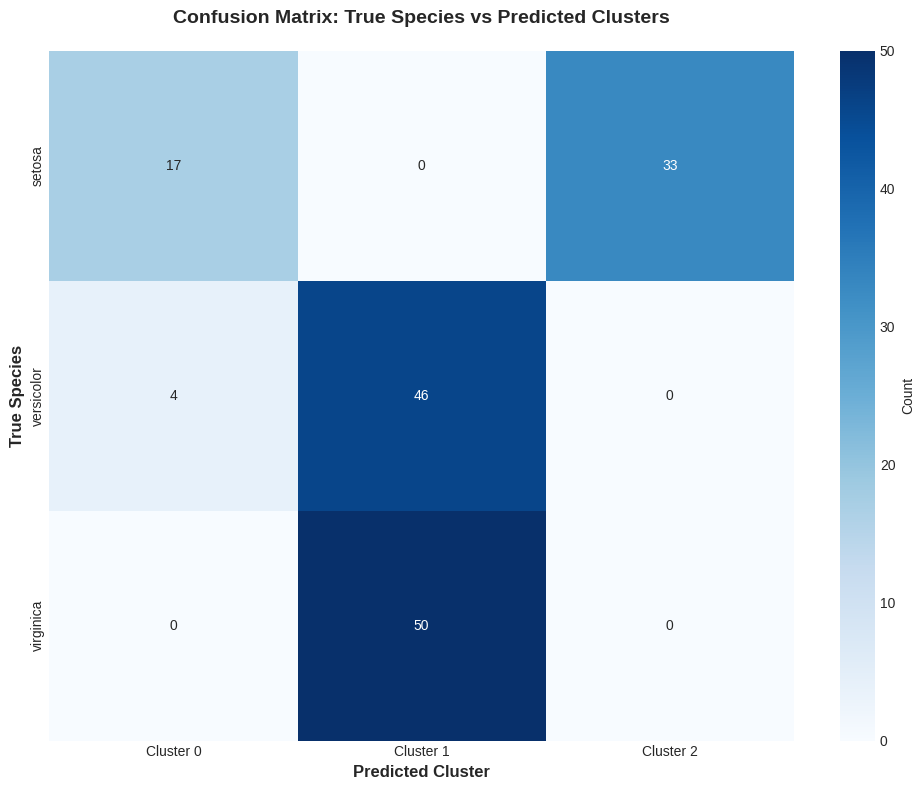


📊 Confusion Matrix Analysis:
Each row represents a true species, and each column represents a predicted cluster.
Ideally, we want to see high values along the diagonal (after potential label permutation).


In [9]:
from sklearn.metrics import confusion_matrix

# Create confusion matrix
cm = confusion_matrix(y_true, y_pred)

# Visualize confusion matrix
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=[f'Cluster {i}' for i in range(3)],
            yticklabels=target_names,
            cbar_kws={'label': 'Count'})
plt.title('Confusion Matrix: True Species vs Predicted Clusters',
          fontsize=14, fontweight='bold', pad=20)
plt.ylabel('True Species', fontsize=12, fontweight='bold')
plt.xlabel('Predicted Cluster', fontsize=12, fontweight='bold')
plt.tight_layout()
plt.show()

print("\n📊 Confusion Matrix Analysis:")
print("Each row represents a true species, and each column represents a predicted cluster.")
print("Ideally, we want to see high values along the diagonal (after potential label permutation).")

## 7. Visualizing the Clustering Results

Now let's visualize our clusters! Since we have 4 features, I'll use PCA to reduce to 2D for visualization, and also show scatter plots of the most important feature pairs.

PCA explained variance ratio: [0.72962445 0.22850762]
Total variance explained: 95.81%


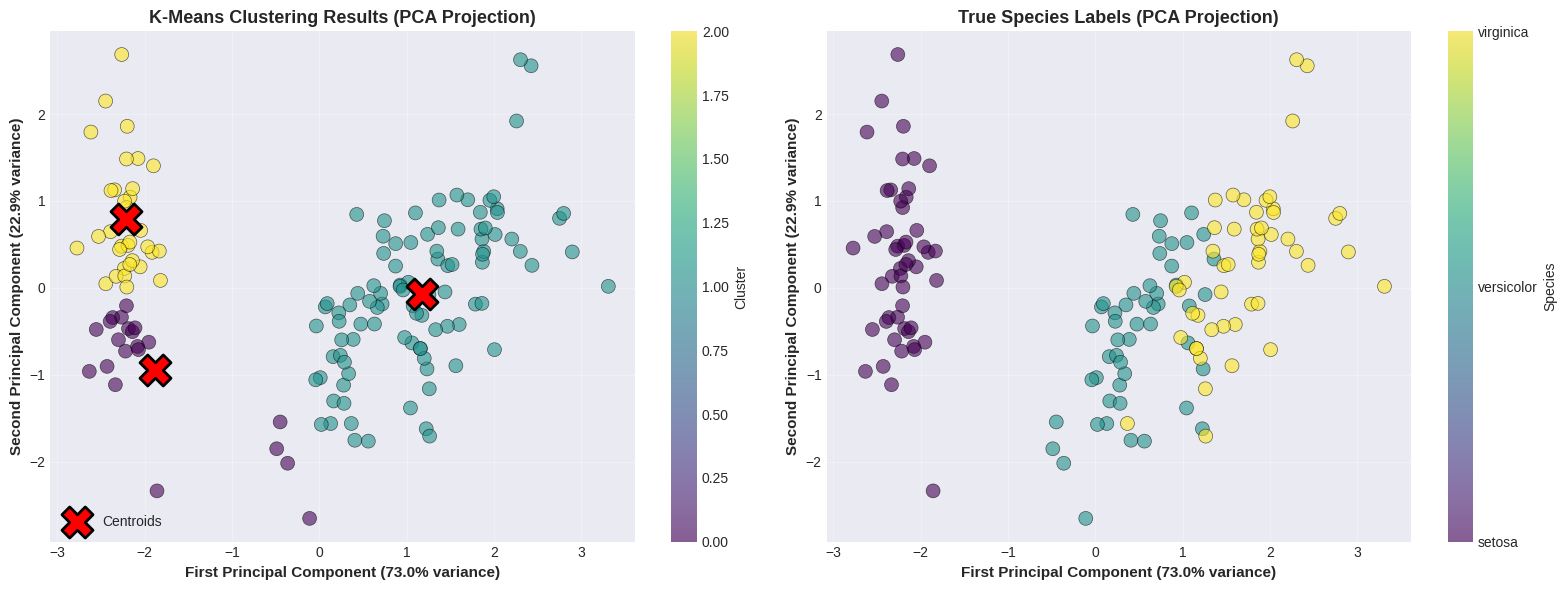

In [10]:
from sklearn.decomposition import PCA

# Reduce to 2D using PCA for visualization
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_scaled)
centroids_pca = pca.transform(kmeans.centroids)

print(f"PCA explained variance ratio: {pca.explained_variance_ratio_}")
print(f"Total variance explained: {pca.explained_variance_ratio_.sum():.2%}")

# Create visualization
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# Plot 1: Predicted clusters
scatter1 = axes[0].scatter(X_pca[:, 0], X_pca[:, 1], c=y_pred,
                          cmap='viridis', s=100, alpha=0.6, edgecolors='black', linewidth=0.5)
axes[0].scatter(centroids_pca[:, 0], centroids_pca[:, 1],
               marker='X', s=500, c='red', edgecolors='black', linewidth=2,
               label='Centroids', zorder=10)
axes[0].set_xlabel(f'First Principal Component ({pca.explained_variance_ratio_[0]:.1%} variance)',
                   fontsize=11, fontweight='bold')
axes[0].set_ylabel(f'Second Principal Component ({pca.explained_variance_ratio_[1]:.1%} variance)',
                   fontsize=11, fontweight='bold')
axes[0].set_title('K-Means Clustering Results (PCA Projection)', fontsize=13, fontweight='bold')
axes[0].legend()
axes[0].grid(True, alpha=0.3)
plt.colorbar(scatter1, ax=axes[0], label='Cluster')

# Plot 2: True labels
scatter2 = axes[1].scatter(X_pca[:, 0], X_pca[:, 1], c=y_true,
                          cmap='viridis', s=100, alpha=0.6, edgecolors='black', linewidth=0.5)
axes[1].set_xlabel(f'First Principal Component ({pca.explained_variance_ratio_[0]:.1%} variance)',
                   fontsize=11, fontweight='bold')
axes[1].set_ylabel(f'Second Principal Component ({pca.explained_variance_ratio_[1]:.1%} variance)',
                   fontsize=11, fontweight='bold')
axes[1].set_title('True Species Labels (PCA Projection)', fontsize=13, fontweight='bold')
axes[1].grid(True, alpha=0.3)
cbar2 = plt.colorbar(scatter2, ax=axes[1], label='Species')
cbar2.set_ticks([0, 1, 2])
cbar2.set_ticklabels(target_names)

plt.tight_layout()
plt.show()

### Feature Space Visualization

Let me also visualize the clusters in the original feature space, using the two most informative features (petal length and petal width).

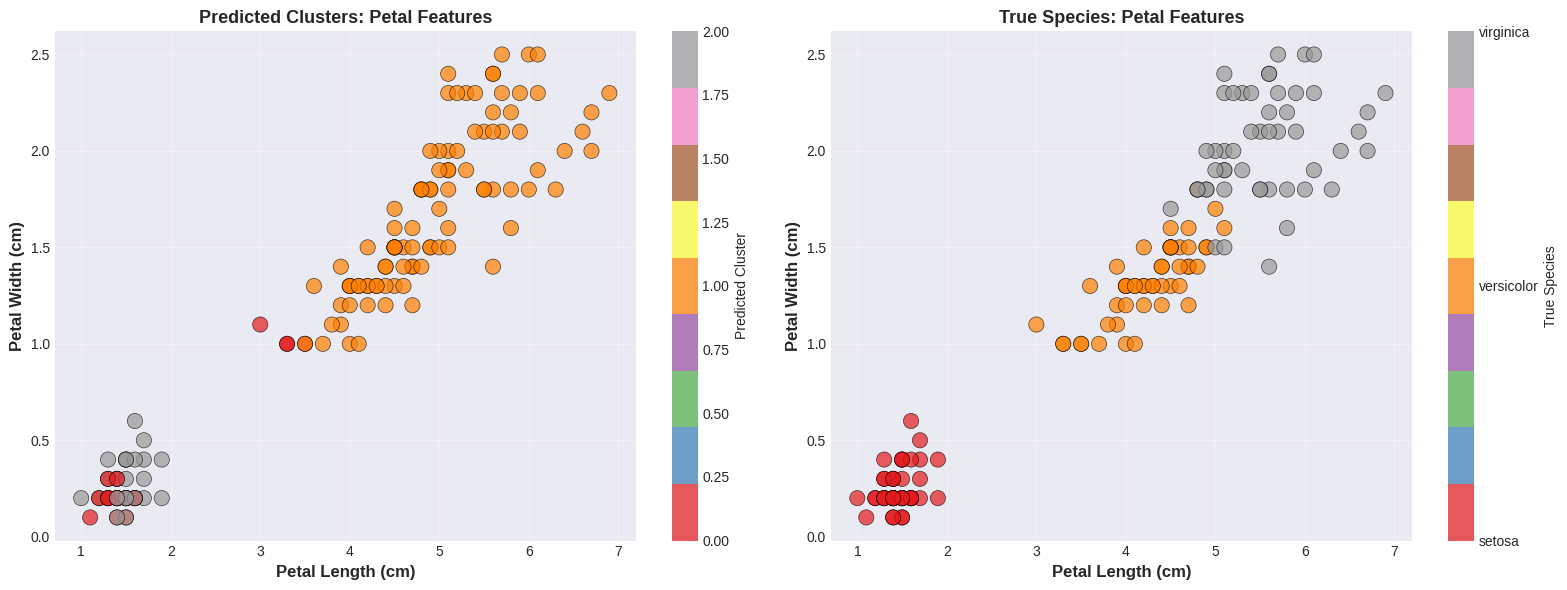


💡 Observation:
The petal features (length and width) show the clearest separation between clusters.
This makes sense as these are the most discriminative features for iris species!


In [11]:
# Use original (unscaled) data for better interpretability
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# Petal length vs Petal width - Predicted
scatter1 = axes[0].scatter(X[:, 2], X[:, 3], c=y_pred,
                          cmap='Set1', s=120, alpha=0.7, edgecolors='black', linewidth=0.5)
axes[0].set_xlabel('Petal Length (cm)', fontsize=12, fontweight='bold')
axes[0].set_ylabel('Petal Width (cm)', fontsize=12, fontweight='bold')
axes[0].set_title('Predicted Clusters: Petal Features', fontsize=13, fontweight='bold')
axes[0].grid(True, alpha=0.3)
plt.colorbar(scatter1, ax=axes[0], label='Predicted Cluster')

# Petal length vs Petal width - True labels
scatter2 = axes[1].scatter(X[:, 2], X[:, 3], c=y_true,
                          cmap='Set1', s=120, alpha=0.7, edgecolors='black', linewidth=0.5)
axes[1].set_xlabel('Petal Length (cm)', fontsize=12, fontweight='bold')
axes[1].set_ylabel('Petal Width (cm)', fontsize=12, fontweight='bold')
axes[1].set_title('True Species: Petal Features', fontsize=13, fontweight='bold')
axes[1].grid(True, alpha=0.3)
cbar2 = plt.colorbar(scatter2, ax=axes[1], label='True Species')
cbar2.set_ticks([0, 1, 2])
cbar2.set_ticklabels(target_names)

plt.tight_layout()
plt.show()

print("\n💡 Observation:")
print("The petal features (length and width) show the clearest separation between clusters.")
print("This makes sense as these are the most discriminative features for iris species!")

## 8. Comparing Random vs K-Means++ Initialization

Let me demonstrate why k-means++ initialization is better than random initialization by running multiple trials.

Running 10 trials for each initialization method...

Trial 1: Random=139.825, K-means++=191.025
Trial 2: Random=139.825, K-means++=140.902
Trial 3: Random=139.820, K-means++=140.902
Trial 4: Random=140.902, K-means++=140.033
Trial 5: Random=140.082, K-means++=191.025
Trial 6: Random=140.033, K-means++=140.033
Trial 7: Random=140.033, K-means++=140.902
Trial 8: Random=140.033, K-means++=140.902
Trial 9: Random=191.025, K-means++=140.033
Trial 10: Random=140.033, K-means++=191.025


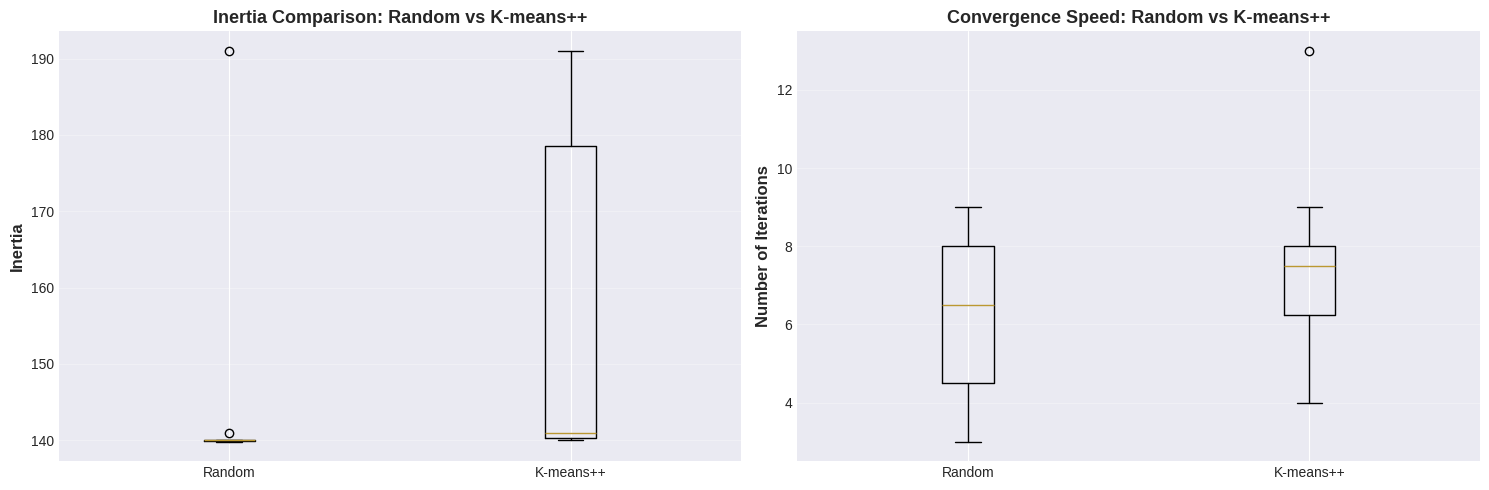


INITIALIZATION COMPARISON RESULTS

Random Initialization:
  Average Inertia: 145.1611 (±15.2908)
  Average Iterations: 6.4 (±2.1)

K-means++ Initialization:
  Average Inertia: 155.6779 (±23.1428)
  Average Iterations: 7.5 (±2.3)

💡 K-means++ typically provides more consistent results with lower variance!


In [12]:
# Compare initialization methods
n_trials = 10
random_inertias = []
kmeanspp_inertias = []
random_iterations = []
kmeanspp_iterations = []

print("Running 10 trials for each initialization method...\n")

for trial in range(n_trials):
    # Random initialization
    km_random = KMeansFromScratch(n_clusters=3, init_method='random', max_iterations=300)
    km_random.fit(X_scaled)
    random_inertias.append(km_random.inertia_)
    random_iterations.append(km_random.n_iterations_)

    # K-means++ initialization
    km_pp = KMeansFromScratch(n_clusters=3, init_method='kmeans++', max_iterations=300)
    km_pp.fit(X_scaled)
    kmeanspp_inertias.append(km_pp.inertia_)
    kmeanspp_iterations.append(km_pp.n_iterations_)

    print(f"Trial {trial+1}: Random={km_random.inertia_:.3f}, K-means++={km_pp.inertia_:.3f}")

# Create comparison plots
fig, axes = plt.subplots(1, 2, figsize=(15, 5))

# Inertia comparison
axes[0].boxplot([random_inertias, kmeanspp_inertias], labels=['Random', 'K-means++'])
axes[0].set_ylabel('Inertia', fontsize=12, fontweight='bold')
axes[0].set_title('Inertia Comparison: Random vs K-means++', fontsize=13, fontweight='bold')
axes[0].grid(True, alpha=0.3, axis='y')

# Iterations comparison
axes[1].boxplot([random_iterations, kmeanspp_iterations], labels=['Random', 'K-means++'])
axes[1].set_ylabel('Number of Iterations', fontsize=12, fontweight='bold')
axes[1].set_title('Convergence Speed: Random vs K-means++', fontsize=13, fontweight='bold')
axes[1].grid(True, alpha=0.3, axis='y')

plt.tight_layout()
plt.show()

print("\n" + "="*60)
print("INITIALIZATION COMPARISON RESULTS")
print("="*60)
print(f"\nRandom Initialization:")
print(f"  Average Inertia: {np.mean(random_inertias):.4f} (±{np.std(random_inertias):.4f})")
print(f"  Average Iterations: {np.mean(random_iterations):.1f} (±{np.std(random_iterations):.1f})")
print(f"\nK-means++ Initialization:")
print(f"  Average Inertia: {np.mean(kmeanspp_inertias):.4f} (±{np.std(kmeanspp_inertias):.4f})")
print(f"  Average Iterations: {np.mean(kmeanspp_iterations):.1f} (±{np.std(kmeanspp_iterations):.1f})")
print("\n💡 K-means++ typically provides more consistent results with lower variance!")
print("="*60)

## 9. Testing on a More Complex Dataset

Let me also test our implementation on synthetic data with different cluster shapes to see its limitations.

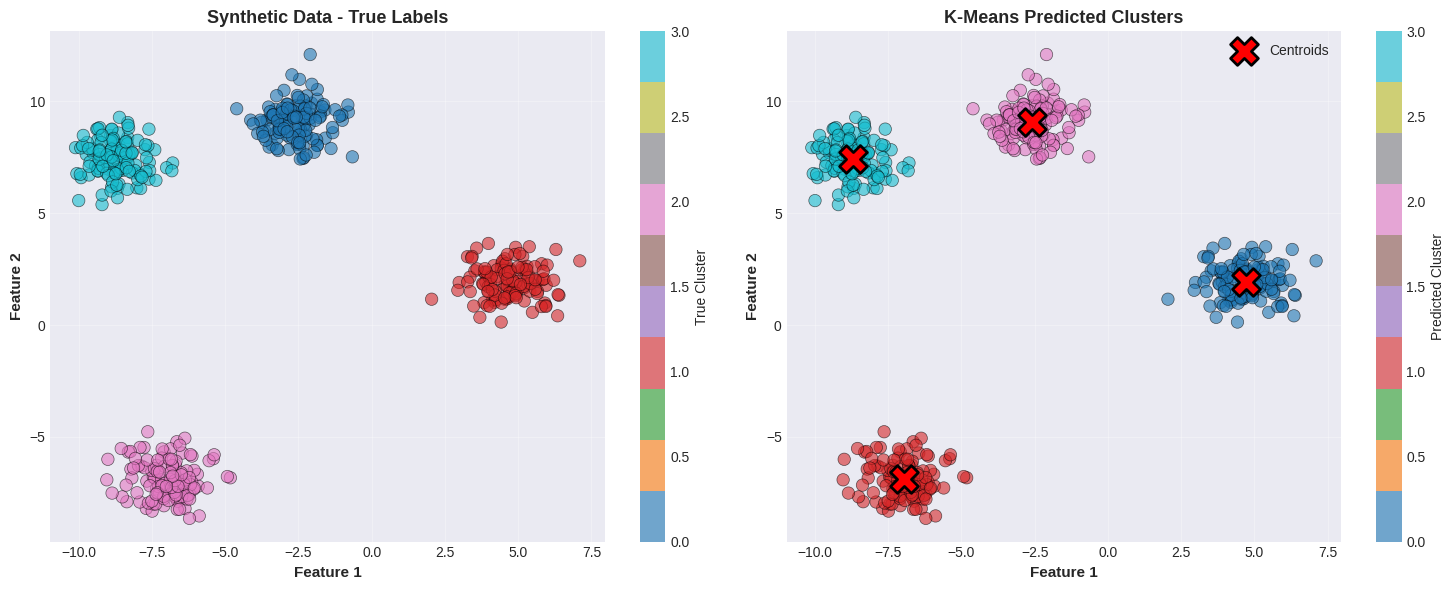


Synthetic Dataset Results:
Silhouette Score: 0.8393
Adjusted Rand Index: 1.0000
Converged in 2 iterations
Final Inertia: 18.6561


In [16]:
# Generate synthetic dataset with clear blobs
X_blobs, y_blobs = make_blobs(n_samples=500, n_features=2, centers=4,
                              cluster_std=0.8, random_state=42)

# Standardize
blobs_scaler = StandardScaler() # Create a new scaler for blobs data
X_blobs_scaled = blobs_scaler.fit_transform(X_blobs)

# Apply K-Means
kmeans_blobs = KMeansFromScratch(n_clusters=4, init_method='kmeans++', max_iterations=300)
kmeans_blobs.fit(X_blobs_scaled)
y_blobs_pred = kmeans_blobs.labels_

# Visualize
fig, axes = plt.subplots(1, 2, figsize=(15, 6))

# True labels
scatter1 = axes[0].scatter(X_blobs[:, 0], X_blobs[:, 1], c=y_blobs,
                          cmap='tab10', s=80, alpha=0.6, edgecolors='black', linewidth=0.5)
axes[0].set_title('Synthetic Data - True Labels', fontsize=13, fontweight='bold')
axes[0].set_xlabel('Feature 1', fontsize=11, fontweight='bold')
axes[0].set_ylabel('Feature 2', fontsize=11, fontweight='bold')
axes[0].grid(True, alpha=0.3)
plt.colorbar(scatter1, ax=axes[0], label='True Cluster')

# Predicted labels
scatter2 = axes[1].scatter(X_blobs[:, 0], X_blobs[:, 1], c=y_blobs_pred,
                          cmap='tab10', s=80, alpha=0.6, edgecolors='black', linewidth=0.5)
# Plot centroids
# Use the blobs_scaler to inverse transform the centroids
axes[1].scatter(blobs_scaler.inverse_transform(kmeans_blobs.centroids)[:, 0],
               blobs_scaler.inverse_transform(kmeans_blobs.centroids)[:, 1],
               marker='X', s=400, c='red', edgecolors='black', linewidth=2,
               label='Centroids', zorder=10)
axes[1].set_title('K-Means Predicted Clusters', fontsize=13, fontweight='bold')
axes[1].set_xlabel('Feature 1', fontsize=11, fontweight='bold')
axes[1].set_ylabel('Feature 2', fontsize=11, fontweight='bold')
axes[1].grid(True, alpha=0.3)
axes[1].legend()
plt.colorbar(scatter2, ax=axes[1], label='Predicted Cluster')

plt.tight_layout()
plt.show()

# Calculate metrics
print("\nSynthetic Dataset Results:")
print(f"Silhouette Score: {silhouette_score(X_blobs_scaled, y_blobs_pred):.4f}")
print(f"Adjusted Rand Index: {adjusted_rand_score(y_blobs, y_blobs_pred):.4f}")
print(f"Converged in {kmeans_blobs.n_iterations_} iterations")
print(f"Final Inertia: {kmeans_blobs.inertia_:.4f}")

## 10. Summary and Key Takeaways

Let me summarize what we've learned from implementing K-Means from scratch:

### Key Learnings:

1. **Algorithm Steps**: K-Means iteratively assigns points to nearest centroids and updates centroid positions until convergence.

2. **Initialization Matters**: K-means++ initialization provides more stable and consistent results compared to random initialization.

3. **Feature Scaling**: Standardization is crucial for K-Means since it uses Euclidean distance, which is sensitive to feature scales.

4. **Evaluation Metrics**:
   - **Silhouette Score**: Measures how similar points are to their own cluster vs other clusters
   - **Davies-Bouldin Index**: Lower values indicate better separation between clusters
   - **Calinski-Harabasz Score**: Higher values indicate denser, well-separated clusters
   - **ARI/NMI**: Useful when ground truth labels are available

5. **Strengths**:
   - Simple and easy to understand
   - Fast and scales well to large datasets
   - Works well when clusters are spherical and well-separated

6. **Limitations**:
   - Assumes clusters are spherical and roughly equal-sized
   - Sensitive to outliers
   - Requires specifying K in advance
   - Can converge to local optima
   - Doesn't work well with non-convex cluster shapes

### What I Found Interesting:

- The Iris dataset is almost perfectly clustered by K-Means, showing high agreement with true species labels
- K-means++ initialization significantly reduces variance in final results
- The petal features (length and width) are much more discriminative than sepal features for clustering iris flowers

### Personal Reflection:

Building K-Means from scratch really helped me understand why certain design choices matter. For example, I initially didn't realize how much initialization affects the final result until I ran multiple trials. The algorithm is elegant in its simplicity, but that simplicity also means it has clear limitations - it really assumes your clusters are nice, round blobs!

For real-world applications, I'd probably want to:
- Try multiple values of K and compare results
- Run the algorithm multiple times and pick the best result
- Consider other clustering algorithms (like DBSCAN or hierarchical clustering) for non-spherical clusters
- Always visualize the results when possible!